# CIFAR-10: TensorFlow Lite Quantization Benchmark

This notebook trains a small CNN on CIFAR-10, converts it to multiple TensorFlow Lite (TFLite) formats, and compares accuracy, file size, and throughput.

**Variants**
- Keras FP32 (baseline)
- TFLite FP32 (no quantization)
- TFLite FP16 (float16) quantization
- TFLite INT8 Dynamic Range quantization
- TFLite INT8 Full Integer quantization (with representative dataset)

You can tweak `EPOCHS`, `MAX_EVAL_SAMPLES`, and model size to balance runtime vs. accuracy.

**Requirements**: `tensorflow>=2.10`, `numpy`, `matplotlib` (for optional plots)


In [1]:
#@title Setup (imports & hyperparameters)
import os, time, tempfile, numpy as np
import tensorflow as tf
from pathlib import Path

EPOCHS = 3                 #@param {type:"integer"}
BATCH_SIZE = 128           #@param {type:"integer"}
MAX_EVAL_SAMPLES = 2000    #@param {type:"integer"}
SEED = 42                  #@param {type:"integer"}
np.random.seed(SEED)
tf.random.set_seed(SEED)
print('TensorFlow:', tf.__version__)


TensorFlow: 2.15.0


In [3]:
#@title Load CIFAR-10 from Tsinghua Mirror
import os
os.environ["CIFAR10_URL"] = "https://mirror.cs.tuna.tsinghua.edu.cn/keras/datasets/cifar-10-batches-py.tar.gz"

from tensorflow.keras.datasets import cifar10
#@title Load CIFAR-10
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()
y_train = y_train.flatten()
y_test = y_test.flatten()

# Normalize to [0,1]
x_train = x_train.astype('float32') / 255.0
x_test  = x_test.astype('float32') / 255.0

if MAX_EVAL_SAMPLES is not None and MAX_EVAL_SAMPLES < len(x_test):
    idx = np.random.permutation(len(x_test))[:MAX_EVAL_SAMPLES]
    x_eval = x_test[idx]
    y_eval = y_test[idx]
else:
    x_eval, y_eval = x_test, y_test
print('Train:', x_train.shape, 'Test:', x_test.shape, 'Eval:', x_eval.shape)

A local file was found, but it seems to be incomplete or outdated because the auto file hash does not match the original value of 6d958be074577803d12ecdefd02955f39262c83c16fe9348329d7fe0b5c001ce so we will re-download the data.
170498071/170498071 [==============================] - 46s 0us/step
Train: (50000, 32, 32, 3) Test: (10000, 32, 32, 3) Eval: (2000, 32, 32, 3)


In [4]:
#@title Define & Train a Small CNN
def make_small_cnn():
    inputs = tf.keras.Input(shape=(32, 32, 3))
    x = tf.keras.layers.Conv2D(32, 3, activation='relu', padding='same')(inputs)
    x = tf.keras.layers.MaxPooling2D()(x)
    x = tf.keras.layers.Conv2D(64, 3, activation='relu', padding='same')(x)
    x = tf.keras.layers.MaxPooling2D()(x)
    x = tf.keras.layers.Conv2D(128, 3, activation='relu', padding='same')(x)
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = tf.keras.layers.Dropout(0.3)(x)
    outputs = tf.keras.layers.Dense(10, activation='softmax')(x)
    model = tf.keras.Model(inputs, outputs)
    model.compile(optimizer=tf.keras.optimizers.Adam(1e-3),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model

model = make_small_cnn()
model.summary()
history = model.fit(
    x_train, y_train,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_split=0.1,
    verbose=2
)
base_loss, base_acc = model.evaluate(x_eval, y_eval, verbose=0)
print(f'[Keras FP32] accuracy on eval set: {base_acc:.4f}')



Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 conv2d (Conv2D)             (None, 32, 32, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 16, 16, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 16, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 8, 8, 64)          0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 8, 8, 128)         7385

In [5]:
#@title Export SavedModel
saved_dir = tempfile.mkdtemp()
model.save(saved_dir, include_optimizer=False)
print('SavedModel exported to:', saved_dir)

INFO:tensorflow:Assets written to: C:\Users\liuzu\AppData\Local\Temp\tmp7inngbx8\assets


INFO:tensorflow:Assets written to: C:\Users\liuzu\AppData\Local\Temp\tmp7inngbx8\assets


SavedModel exported to: C:\Users\liuzu\AppData\Local\Temp\tmp7inngbx8


In [6]:
#@title Helper Functions: TFLite Conversion & Inference
def get_file_size(path):
    return os.path.getsize(path) / 1024.0 / 1024.0  # MB

def tflite_infer(interpreter, images, labels):
    input_details = interpreter.get_input_details()[0]
    output_details = interpreter.get_output_details()[0]
    input_index = input_details['index']
    output_index = output_details['index']
    scale, zero_point = input_details['quantization']
    is_quant_input = (input_details['dtype'] in [np.uint8, np.int8])

    correct = 0
    n = len(images)
    start = time.time()
    for i in range(n):
        img = images[i:i+1]
        if is_quant_input:
            if input_details['dtype'] == np.uint8:
                q = np.clip(np.round(img / scale + zero_point), 0, 255).astype(np.uint8)
            else:
                q = np.clip(np.round(img / scale + zero_point), -128, 127).astype(np.int8)
            inp = q
        else:
            inp = img.astype(input_details['dtype'])

        if list(inp.shape) != list(input_details['shape']):
            interpreter.resize_tensor_input(input_index, inp.shape)
            interpreter.allocate_tensors()

        interpreter.set_tensor(input_index, inp)
        interpreter.invoke()
        pred = interpreter.get_tensor(output_index)
        pred_label = np.argmax(pred, axis=1)[0]
        if pred_label == labels[i]:
            correct += 1

    elapsed = time.time() - start
    acc = correct / n
    ips = n / elapsed if elapsed > 0 else float('inf')
    return acc, elapsed, ips

def convert_tflite(saved_model_dir, mode='fp32'):
    converter = tf.lite.TFLiteConverter.from_saved_model(saved_model_dir)
    if mode == 'fp32':
        pass
    elif mode == 'fp16':
        converter.optimizations = [tf.lite.Optimize.DEFAULT]
        converter.target_spec.supported_types = [tf.float16]
    elif mode == 'int8_dynamic':
        converter.optimizations = [tf.lite.Optimize.DEFAULT]
    elif mode == 'int8_full':
        converter.optimizations = [tf.lite.Optimize.DEFAULT]
        def representative_data_gen():
            for i in range(200):
                idx = np.random.randint(0, len(x_train))
                sample = x_train[idx:idx+1]
                yield [sample.astype(np.float32)]
        converter.representative_dataset = representative_data_gen
        converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
        converter.inference_input_type  = tf.int8
        converter.inference_output_type = tf.int8
    else:
        raise ValueError('Unknown mode: ' + mode)
    tflite_model = converter.convert()
    tfile = os.path.join(tempfile.mkdtemp(), f'model_{mode}.tflite')
    with open(tfile, 'wb') as f:
        f.write(tflite_model)
    return tfile

In [7]:
#@title Convert: FP32 / FP16 / INT8 (dynamic) / INT8 (full)
paths = {}
modes = ['fp32', 'fp16', 'int8_dynamic', 'int8_full']
for m in modes:
    try:
        p = convert_tflite(saved_dir, mode=m)
        paths[m] = p
        print(f'Exported {m}: {p}')
    except Exception as e:
        print(f'[WARN] {m} export failed: {e}')

Exported fp32: C:\Users\liuzu\AppData\Local\Temp\tmpqhfc8r0l\model_fp32.tflite
Exported fp16: C:\Users\liuzu\AppData\Local\Temp\tmpkvy1dvce\model_fp16.tflite
Exported int8_dynamic: C:\Users\liuzu\AppData\Local\Temp\tmphafe8ci3\model_int8_dynamic.tflite
Exported int8_full: C:\Users\liuzu\AppData\Local\Temp\tmpoibb315c\model_int8_full.tflite


In [8]:
#@title Evaluate All Variants
results = []
for m, p in paths.items():
    print(f'\n=== Evaluating TFLite {m} ===')
    interpreter = tf.lite.Interpreter(model_path=p)
    interpreter.allocate_tensors()
    acc, elapsed, ips = tflite_infer(interpreter, x_eval, y_eval)
    size_mb = os.path.getsize(p) / 1024 / 1024
    results.append((m, acc, size_mb, elapsed, ips))
    print(f'[TFLite {m}] acc={acc:.4f}, size={size_mb:.2f} MB, time={elapsed:.2f}s, images/sec={ips:.1f}')

print('\n====== Summary (eval set size: {}) ======'.format(len(x_eval)))
print(f'[Keras FP32] acc={base_acc:.4f}, size=N/A')
for m, acc, size_mb, elapsed, ips in results:
    print(f'[TFLite {m:11s}] acc={acc:.4f}, size={size_mb:5.2f} MB, images/sec={ips:6.1f}')


=== Evaluating TFLite fp32 ===
[TFLite fp32] acc=0.4615, size=0.36 MB, time=1.19s, images/sec=1686.2

=== Evaluating TFLite fp16 ===
[TFLite fp16] acc=0.4630, size=0.18 MB, time=1.20s, images/sec=1668.6

=== Evaluating TFLite int8_dynamic ===
[TFLite int8_dynamic] acc=0.4610, size=0.10 MB, time=2.87s, images/sec=697.6

=== Evaluating TFLite int8_full ===
[TFLite int8_full] acc=0.4630, size=0.10 MB, time=0.77s, images/sec=2605.9

====== Summary (eval set size: 2000) ======
[Keras FP32] acc=0.4615, size=N/A
[TFLite fp32       ] acc=0.4615, size= 0.36 MB, images/sec=1686.2
[TFLite fp16       ] acc=0.4630, size= 0.18 MB, images/sec=1668.6
[TFLite int8_dynamic] acc=0.4610, size= 0.10 MB, images/sec= 697.6
[TFLite int8_full  ] acc=0.4630, size= 0.10 MB, images/sec=2605.9


# Visualize Results
Run this cell to visualize accuracy and model size comparisons.

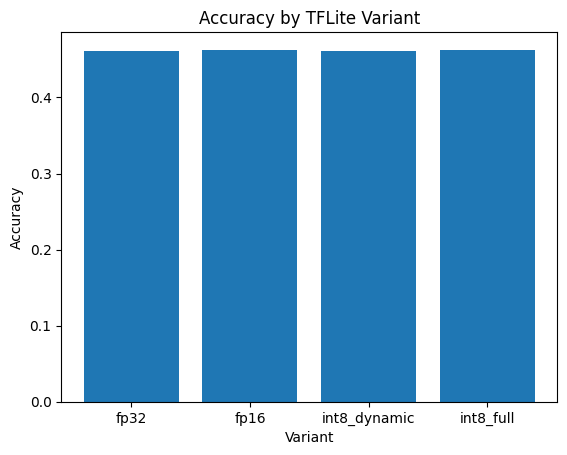

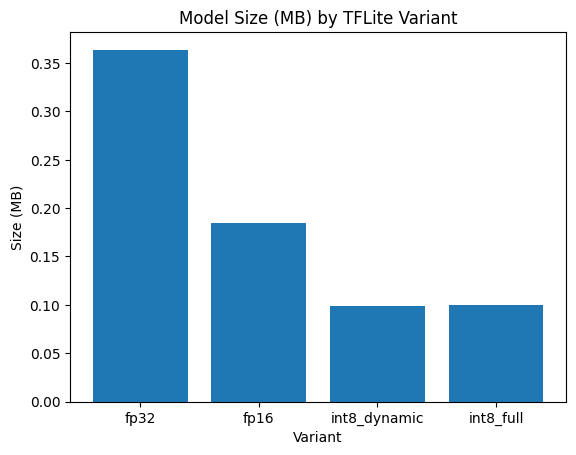

In [12]:
#@title Plot Accuracy & Size (Optional)
import matplotlib.pyplot as plt
labels = [r[0] for r in results]
accs = [r[1] for r in results]
sizes = [r[2] for r in results]

plt.figure()
plt.bar(labels, accs)
plt.title('Accuracy by TFLite Variant')
plt.xlabel('Variant')
plt.ylabel('Accuracy')
plt.show()

plt.figure()
plt.bar(labels, sizes)
plt.title('Model Size (MB) by TFLite Variant')
plt.xlabel('Variant')
plt.ylabel('Size (MB)')
plt.show()